# Network with arbitrary hidden layers

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import helper

In [4]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5], inplace=True)])
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [5]:
class MyNetwork(nn.Module):
    
    def __init__(self, input_size, output_size, hidden_layers, drop_prob =0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
            drop_p: float between 0 and 1, dropout probability
        '''
        # super() calls super classe's constructor so nn.Module constructor here
        super().__init__()
        
        # Add the first layer = input => first hidden layer, then extend to other layers
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(hl1,hl2) for (hl1,hl2) in layer_sizes])
        self.output = nn.Linear(hidden_layers[-1],output_size)

        # Set dropout probability
        self.dropout = nn.Dropout(p=drop_prob)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        # Forward pass with ReLU and dropout 
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)
            
        x = self.output(x)
        return F.log_softmax(x, dim=1)

In [6]:
# Create network, criterion and optimizer
model = MyNetwork(784, 10, [512,256,128], drop_prob=0.5)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Implement function for validation pass
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:
        images.resize_(images.shape[0], 784)
        
        # one batch is processed
        output = model.forward(images)
        # loss is computed
        test_loss += criterion(output, labels).item()
        
        # we inverse log to get probabilities
        probabilities = torch.exp(output)
        # probabililites.max() outputs 2-element array,
        # first element = array of length 64 with highest probabilities for each sample
        # second element = array of length 64 with according indexes of those probabilities
        # e.g if for the 1st image in batch the highest probabiliy was for class 4 we get 
        # index 4-1 = 3
        equality = (labels.data == probabilities.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    return test_loss, accuracy

In [8]:
# Training network
epochs = 5
steps = 0
running_loss = 0
print_every = 40
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        steps += 1
        
        # Flatt image
        images.resize_(images.shape[0], 784)
        # Zero-out optimizer
        optimizer.zero_grad()
        
        # forward pass and backpropagation
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            # Put network into eval mode => dropout is turned off
            model.eval()
            # Turn of gradients also
            with torch.no_grad():
                test_loss , accuracy = validation(model, testloader, criterion)
            
            print(f"Epoch: {epoch+1}/{epochs}",
                 f"Training Loss: {(running_loss/print_every):.3f}",
                 f"Test Loss: {(test_loss/len(testloader)):.3f}",
                 f"Test Accuracy: {(accuracy/len(testloader)):.3f}")
            running_loss = 0
            
            # Get back to the train mode
            model.train()

Epoch: 1/5 Training Loss: 1.727 Test Loss: 0.978 Test Accuracy: 0.657
Epoch: 1/5 Training Loss: 1.014 Test Loss: 0.756 Test Accuracy: 0.705
Epoch: 1/5 Training Loss: 0.928 Test Loss: 0.685 Test Accuracy: 0.739
Epoch: 1/5 Training Loss: 0.802 Test Loss: 0.642 Test Accuracy: 0.747
Epoch: 1/5 Training Loss: 0.726 Test Loss: 0.651 Test Accuracy: 0.747
Epoch: 1/5 Training Loss: 0.720 Test Loss: 0.609 Test Accuracy: 0.763
Epoch: 1/5 Training Loss: 0.691 Test Loss: 0.576 Test Accuracy: 0.781
Epoch: 1/5 Training Loss: 0.721 Test Loss: 0.572 Test Accuracy: 0.791
Epoch: 1/5 Training Loss: 0.672 Test Loss: 0.561 Test Accuracy: 0.793
Epoch: 1/5 Training Loss: 0.671 Test Loss: 0.558 Test Accuracy: 0.787
Epoch: 1/5 Training Loss: 0.613 Test Loss: 0.547 Test Accuracy: 0.801
Epoch: 1/5 Training Loss: 0.637 Test Loss: 0.560 Test Accuracy: 0.798
Epoch: 1/5 Training Loss: 0.630 Test Loss: 0.528 Test Accuracy: 0.805
Epoch: 1/5 Training Loss: 0.610 Test Loss: 0.531 Test Accuracy: 0.808
Epoch: 1/5 Training 

torch.Size([1, 784]) <class 'torch.Tensor'>
tensor(2)


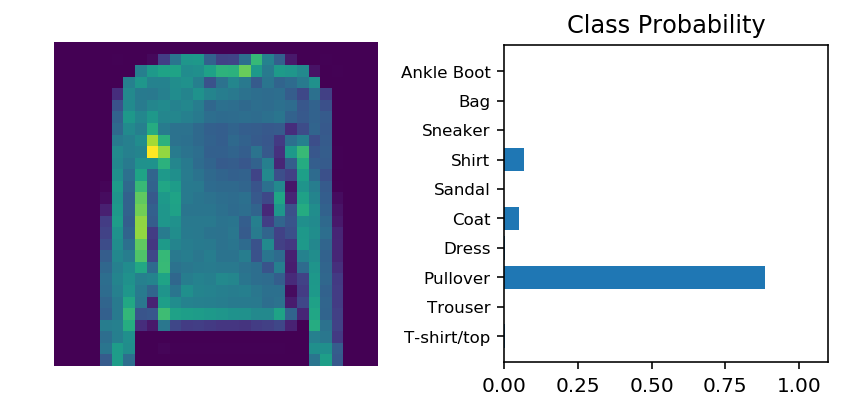

In [25]:
# evaluation
# put model into eval mode
model.eval()

dataiter = iter(testloader)
images , labels = dataiter.next()
# extract first image
img = images[11]
# conver to vector
img = img.view(1,784)
print(img.shape, type(img))

# Calculate class probabilities
with torch.no_grad():
    output = model.forward(img)
probabilities = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1,28,28), probabilities, version="Fashion")
print(labels[11])

# Saving and loading models for further training/usage

#### PyTorch networks are storing parameters in `state_dict`. There we can see weigh and bias matrices for every layer present in network

In [11]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 MyNetwork(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
) 

The state dict keys: 

 odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


#### The simplest way to save a model is to just save `state_dict`

In [12]:
torch.save(model.state_dict(), "checkpoint.pth")

#### To load it just do...

In [14]:
# load previosly saved dictionary
state_dict = torch.load("checkpoint.pth")
# load dict into the network
model.load_state_dict(state_dict)
print(state_dict.keys())

odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


#### ... but there is one more thing. Loading state dict work only if the model architecture is exacly the same as the checkpoint dictionary. So we need to save also model architecture in order to be able to rebuild it

In [24]:
checkpoint = {'input_size' : 784,
             'output_size' : 10,
             'hidden_layers' : [layer.out_features for layer in model.hidden_layers],
             'state_dict' : model.state_dict()}
torch.save(checkpoint, "checkpoint.pth")

#### Function for loading and setting-up the model

In [26]:
def load_checkpoint_set_model(path):
    checkpoint = torch.load(path)
    model = MyNetwork(checkpoint['input_size'],
                     checkpoint['output_size'],
                     checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    return model

In [29]:
model = load_checkpoint_set_model("checkpoint.pth")
print(model)

MyNetwork(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
)
